# Logistic Regression in JAGS

In [1]:
library(boot)

In [2]:
data(urine)

In [3]:
?urine

urine {boot},R Documentation


In [4]:
head(urine)

,r,gravity,ph,osmo,cond,urea,calc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1.021,4.91,725,NA,443,2.45
2,0,1.017,5.74,577,20.0,296,4.49
3,0,1.008,7.20,321,14.9,101,2.36
4,0,1.011,5.51,408,12.6,224,2.15
5,0,1.005,6.52,187,7.5,91,1.16
6,0,1.020,5.27,668,25.3,252,3.34


## Removing missing values

In [5]:
data = na.omit(urine)

In [6]:
head(data)

,r,gravity,ph,osmo,cond,urea,calc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0,1.017,5.74,577,20.0,296,4.49
3,0,1.008,7.20,321,14.9,101,2.36
4,0,1.011,5.51,408,12.6,224,2.15
5,0,1.005,6.52,187,7.5,91,1.16
6,0,1.020,5.27,668,25.3,252,3.34
7,0,1.012,5.62,461,17.4,195,1.40


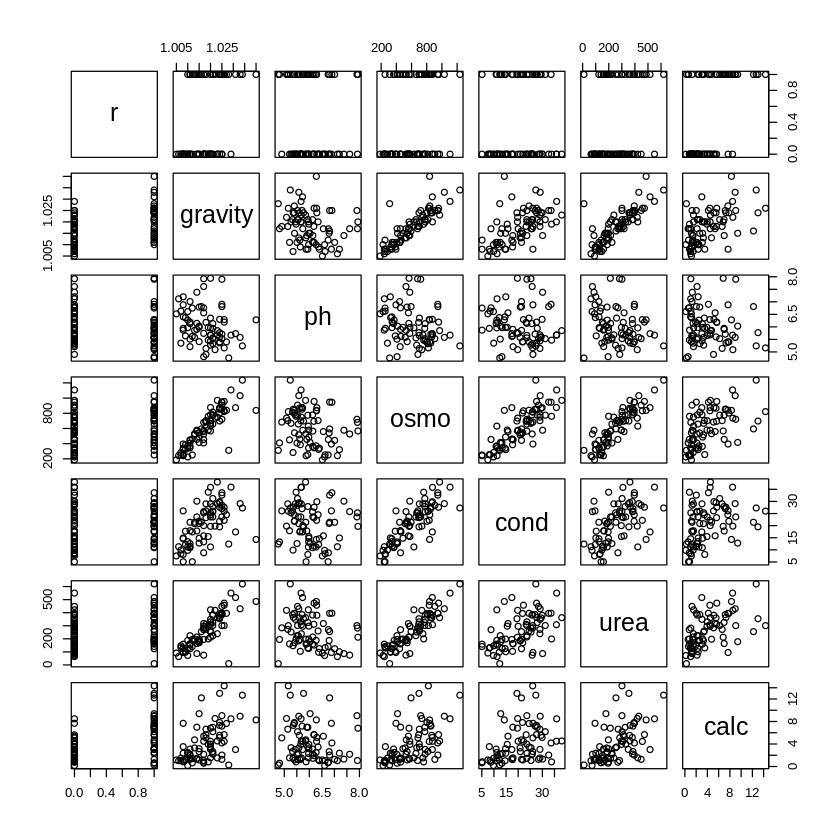

In [7]:
pairs(data)

Note the strong correlation between $\verb|osmolarity|$ and $\verb|specefic gravity|$

This, in reality, causes a problem during Statistical Inference with Linear Regression as the two strongly correlated variables compete for estimation of the response, leading to unstable estimation.

This is not a big problem during Prediction of the response variable.

**However, in this analysis, we are trying to figure out which parameters leads to calcium oxalate crystals in the urine (i.e. estimation), thus we would need to deal with the problem of correlation between the features.**

## 1. Variable Selection

Target : Find the Predictor(s) which are related to the calcium oxalate crystals in the urine

1. One way to do this is to fit various models with different set of variables and see which one of those models have the best Deviance Information Criterion (DIC) value.



2. **Another way to do this is to fit a Linear Model where priors for the Model Coefficients favors values near zero.**

    **Since values near zero favors weak relationship, this way, the burden of determining the association between the variables lies within the data, i.e. if there's not a strong signal then we'll just assume that such an association doesn't exist as the prior favors that scenario.**

    **Rather than finding priors for each coefficient based on it's covariates' scale, it is customary to Standardize each Predictor's value.**


#### 1.1. Standardizing the continous predictors

In [8]:
X = scale(x = data[,-1], center = TRUE, scale = TRUE)

In [9]:
head(X)

,gravity,ph,osmo,cond,urea,calc
2,-0.1403037,-0.4163725,-0.1528785,-0.1130908,0.25747827,0.09997564
3,-1.3710690,1.6055972,-1.2218894,-0.7502609,-1.23693077,-0.54608444
4,-0.9608139,-0.7349020,-0.8585927,-1.0376121,-0.29430353,-0.60978050
5,-1.7813240,0.6638579,-1.7814497,-1.6747822,-1.31356713,-0.91006194
6,0.2699514,-1.0672806,0.2271214,0.5490664,-0.07972172,-0.24883614
7,-0.8240622,-0.5825618,-0.6372741,-0.4379226,-0.51654898,-0.83726644


In [10]:
colMeans(X)

gravity            ph          osmo          cond          urea 
-9.861143e-15  8.511409e-17  1.515743e-16 -1.829852e-16  7.335402e-17 
         calc 
-1.689666e-18

All are basically zero

In [11]:
apply(X, 2, sd)

gravity      ph    osmo    cond    urea    calc 
      1       1       1       1       1       1

All have standard deviation 1

#### 1.2. Priors which favors the coefficients near zero

We'll use double exponential or $Laplace$ $Prior$

In [12]:
ddexp = function(x, mu, tau){
    
    (1/2) * (tau) * exp( -1*tau*abs(x - mu) )
    
}

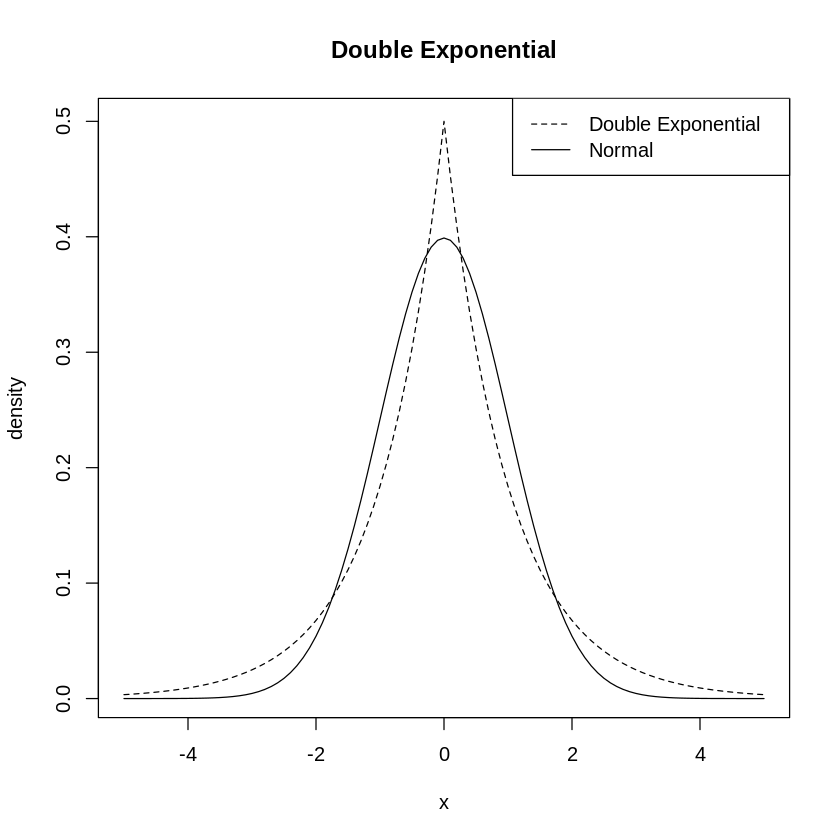

In [13]:
curve(ddexp(x, 0, 1), from = -5, to = 5, lty = 2,ylab = "density", main = "Double Exponential")

curve(dnorm(x,0,1), lty = 1,add = TRUE,main = "Normal Distribution")

legend("topright", legend = c("Double Exponential", "Normal"), lty = c(2,1))

In [14]:
logit(0.6)

[1] 0.4054651

In [15]:
log(0.6/0.4)

[1] 0.4054651

### 1.3. JAGS Model

gravity	ph	osmo	cond	urea	calc

In [16]:
model1_string = "model{
    
    
    #Likelihood
    for (i in 1:length(y)){
        
        y[i] ~ dbern(p[i])
        
        logit(p[i]) = int + beta[1]*gravity[i] + beta[2]*ph[i] + beta[3]*osmo[i] + beta[4]*cond[i] + beta[5]*urea[i] + beta[6]*calc[i]
        
    }
    
    
    
    #Prior
    int ~ dnorm(0, 1/25) #High variance to show uncertainity
    for (i in 1:6){
        
        beta[i] ~ ddexp(0, sqrt(2)) #it will have variance 1
        
    }
    
}"

In [17]:
set.seed(420)

In [18]:
data1_jags = list(y = data$r, gravity = X[,"gravity"], ph = X[,"ph"], osmo = X[,"osmo"], cond = X[,"cond"], urea = X[,"urea"], calc = X[,"calc"])

In [19]:
params = c("int", "beta")

In [20]:
library("rjags")

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [21]:
model1 = jags.model(file = textConnection(model1_string), data = data1_jags, n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 77
   Unobserved stochastic nodes: 7
   Total graph size: 1085

Initializing model



We let jags decide initial values

In [22]:
update(model1, 1000)

In [23]:
mod1_sim = coda.samples(model = model1, variable.names = params, n.iter = 5000)

In [24]:
mod1_csim = as.mcmc(do.call(rbind, mod1_sim))

#### 1.4. Basic Convergence Diagnostics

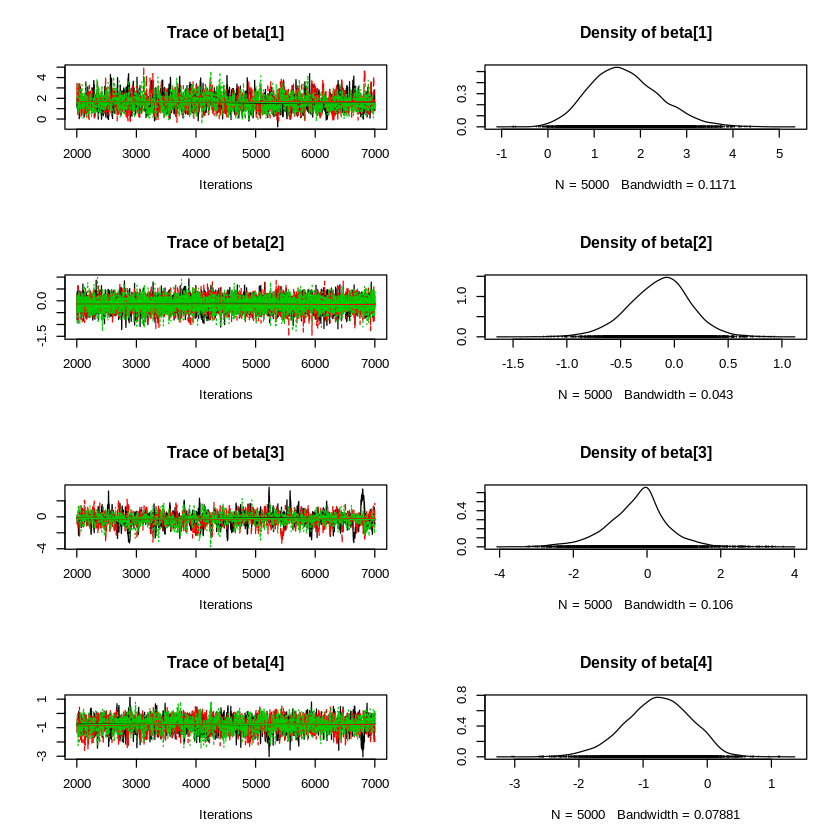

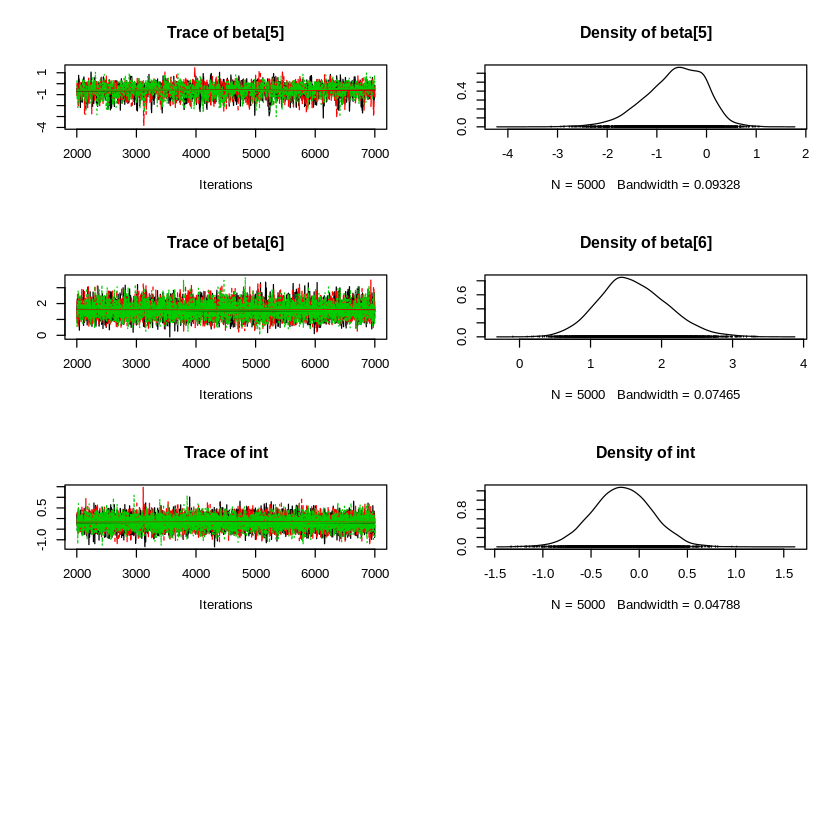

In [25]:
plot(mod1_sim)

#### 1.5. DIC Value

In [26]:
dic_model1 = dic.samples(model = model1, n.iter = 1000)

#### 1.6. Density Plots 

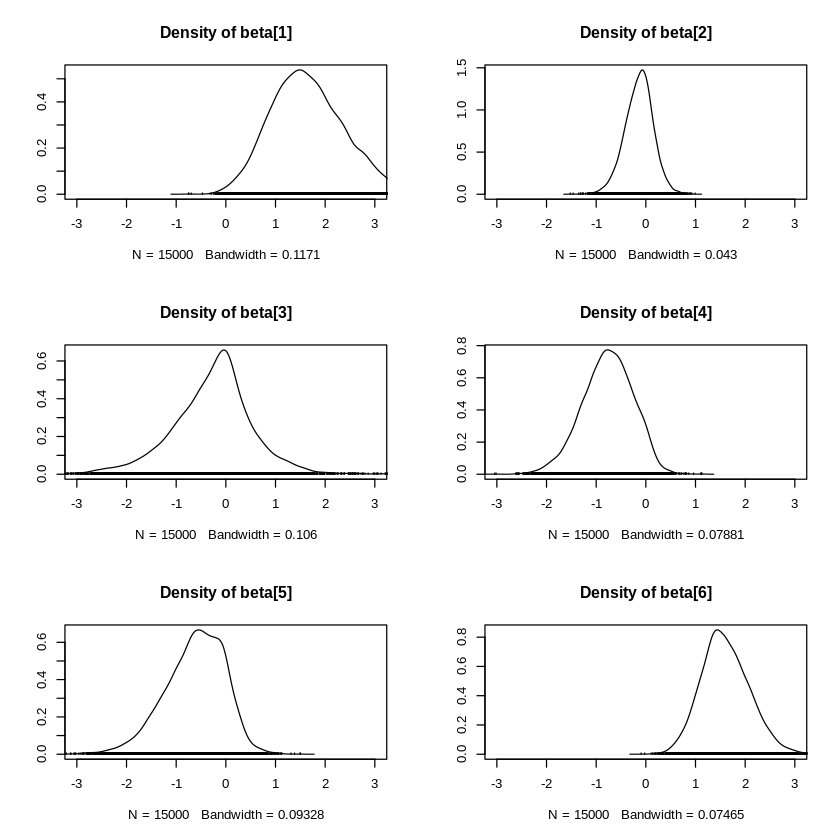

In [27]:
par(mfrow = c(3,2))
densplot(mod1_csim[,1:6], xlim = c(-3,3))

In [28]:
colnames(X)

[1] "gravity" "ph"      "osmo"    "cond"    "urea"    "calc"

We are looking for the evidence that different coefficients are different from zero.

### **Now, notice how the posterior distributions for the beta[2] (ph), beta[3] (osmo) and somewhat beta[5] (urea) has not shifted by much, thus implying that these are not a strong predictor for calcium oxalate crystals.**

### **Thus, we would make a new model only consisting of $\verb|gravity|$, $\verb|cond|$, $\verb|calc|$ as predictor variables as they show highest response to the data for the target.**

## 2. Final Model

In [29]:
model2_string = "model{
    
    
    #Likelihood
    for (i in 1:length(y)){
        
        y[i] ~ dbern(p[i])
        
        logit(p[i]) = int + beta[1]*gravity[i] + beta[2]*cond[i] + beta[3]*calc[i]
        
    }
    
    
    
    #Prior
    int ~ dnorm(0, 1/25) #High variance to show uncertainity
    for (i in 1:3){
        
        beta[i] ~ dnorm(0, 1/25) #Non-informative for logistic regression
        
    }
    
}"

In [30]:
model2 = jags.model(file = textConnection(model2_string),data = data1_jags,n.chains = 3)

Warning message in jags.model(file = textConnection(model2_string), data = data1_jags, :
“Unused variable "ph" in data”
Warning message in jags.model(file = textConnection(model2_string), data = data1_jags, :
“Unused variable "osmo" in data”
Warning message in jags.model(file = textConnection(model2_string), data = data1_jags, :
“Unused variable "urea" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 77
   Unobserved stochastic nodes: 4
   Total graph size: 635

Initializing model



In [31]:
update(model2, 1000)

In [32]:
mod2_sim = coda.samples(model = model2, variable.names = params, n.iter = 5000)

In [33]:
mod2_csim = as.mcmc(do.call(rbind, mod2_sim) )

#### Convergence Diagnostics

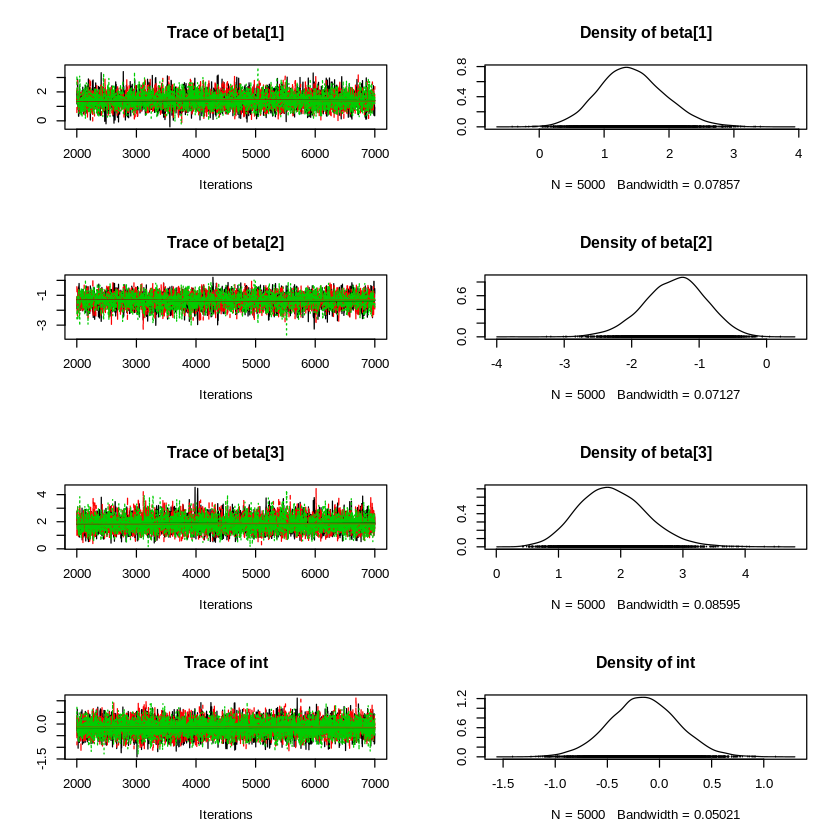

In [34]:
plot(mod2_sim)

In [35]:
gelman.diag(mod2_sim)

Potential scale reduction factors:

        Point est. Upper C.I.
beta[1]          1          1
beta[2]          1          1
beta[3]          1          1
int              1          1

Multivariate psrf

1

In [36]:
autocorr.diag(mod2_sim)

,beta[1],beta[2],beta[3],int
Lag 0,1.000000000,1.000000000,1.0000000000,1.000000000
Lag 1,0.588010977,0.649704127,0.5086660964,0.263284027
Lag 5,0.106689844,0.147155388,0.0488946763,-0.009888111
Lag 10,0.009741317,0.012839944,-0.0061544974,0.001588889
Lag 50,-0.004032672,-0.004935105,0.0005517092,-0.011634040


In [37]:
effectiveSize(mod2_sim)

beta[1]  beta[2]  beta[3]      int 
3414.722 2968.034 4325.508 8457.610

In [38]:
dic2 = dic.samples(model = model2, n.iter = 1e3)

### DIC Comparison

In [39]:
dic_model1

Mean deviance:  69.02 
penalty 5.475 
Penalized deviance: 74.49 

In [40]:
dic2

Mean deviance:  71.15 
penalty 3.975 
Penalized deviance: 75.12 

### Conclusions

In [41]:
summary(mod2_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
beta[1]  1.4271 0.5105 0.004168       0.008742
beta[2] -1.3592 0.4601 0.003757       0.008475
beta[3]  1.8762 0.5549 0.004530       0.008504
int     -0.1527 0.3252 0.002655       0.003542

2. Quantiles for each variable:

           2.5%     25%     50%      75%   97.5%
beta[1]  0.4828  1.0766  1.4000  1.75629  2.4777
beta[2] -2.3070 -1.6604 -1.3392 -1.03995 -0.5057
beta[3]  0.8847  1.4857  1.8428  2.23230  3.0475
int     -0.7879 -0.3699 -0.1553  0.06435  0.4862


In [42]:
colnames(X)

[1] "gravity" "ph"      "osmo"    "cond"    "urea"    "calc"

In [43]:
summary(mod1_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
beta[1]  1.6635 0.7559 0.006172       0.021484
beta[2] -0.1393 0.2872 0.002345       0.003268
beta[3] -0.2707 0.8090 0.006606       0.028634
beta[4] -0.7687 0.5087 0.004154       0.014046
beta[5] -0.6246 0.6021 0.004917       0.015931
beta[6]  1.6033 0.4828 0.003942       0.007004
int     -0.1776 0.3102 0.002533       0.003564

2. Quantiles for each variable:

           2.5%     25%     50%      75%  97.5%
beta[1]  0.3345  1.1269  1.6013  2.14763 3.2774
beta[2] -0.7358 -0.3217 -0.1241  0.05021 0.4106
beta[3] -2.0634 -0.7302 -0.2021  0.18703 1.3089
beta[4] -1.8365 -1.0979 -0.7531 -0.41169 0.1328
beta[5] -1.9443 -1.0002 -0.5699 -0.18012 0.3628
beta[6]  0.7220  1.2725  1.5710  1.91831 2.6119
int     -0.7835 -0.3837 -0.1783  0.03044 0.4229


#### The two models yields same conclusions qualitatively:

1. Increase in Specefic Gravity is associated with Increase in Crystals
2. Increase in Conductivity is associated with Decrease in Crystals
3. Increase in Calcium Concentration in associated with Increase in Crystals

## Gathering Predictions from the Parameters' Estimates

Remember that we modelled the Expected value as the following:-

$\mathbb{E}(y_i) = \phi_i = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_i)}}$

**Therefore, if we have the predictor's value and the parameter's value then we can determine the probability that the Response variable is 1.**

In [44]:
post_means = colMeans(mod2_csim)

In [45]:
post_means

beta[1]    beta[2]    beta[3]        int 
 1.4270954 -1.3591795  1.8761591 -0.1526586

Note that the covariates were made to have zero mean and S.D. 1, that implies that these average values of predictor coefficients represent the deviation from the mean (instead of zero). For Example, the value of intercept (int) is -0.152, which represents the intercept when all the predictor's have their means as their current value, which, due to our standardization of the predictors, implies that the standardized predictors take value zero ($x_i = 0$) i.e. :-

In [47]:
1 / (1 + exp(-(post_means[4])))

int 
0.4619093

**The probability of observing Calcium Crystals at the average values of the above thre predictors is about 0.4619**

### A New Specimen

Consider a new specimen whose value of $\verb|Specefic Gravity|$ is at average, $\verb|Conductivity|$ is 1 SD below the mean, $\verb|Calcium Concentration|$ is 1 SD above the mean. 

In [48]:
1 / (1 + exp( -(post_means[4] + post_means[1] * 0 + post_means[2] * -1 + post_means[3] * 1) ))

int 
0.9561726

That gives us the probability of having Calcium Oxalate Crystals in the urine with the above predictors' values.

## Prediction for the dataset

In [53]:
lin_est = post_means[4] +  X[,c(1,4,6)] %*% post_means[1:3]

In [55]:
y_pred_mod2 = 1 / (1 + exp(-(lin_est)))

In [56]:
head(y_pred_mod2)

2,0.49709892
3,0.10773326
4,0.22139150
5,0.10660778
6,0.27278303
7,0.09076717


Thus, we got the probability of observing the crystals for each point in the dataset

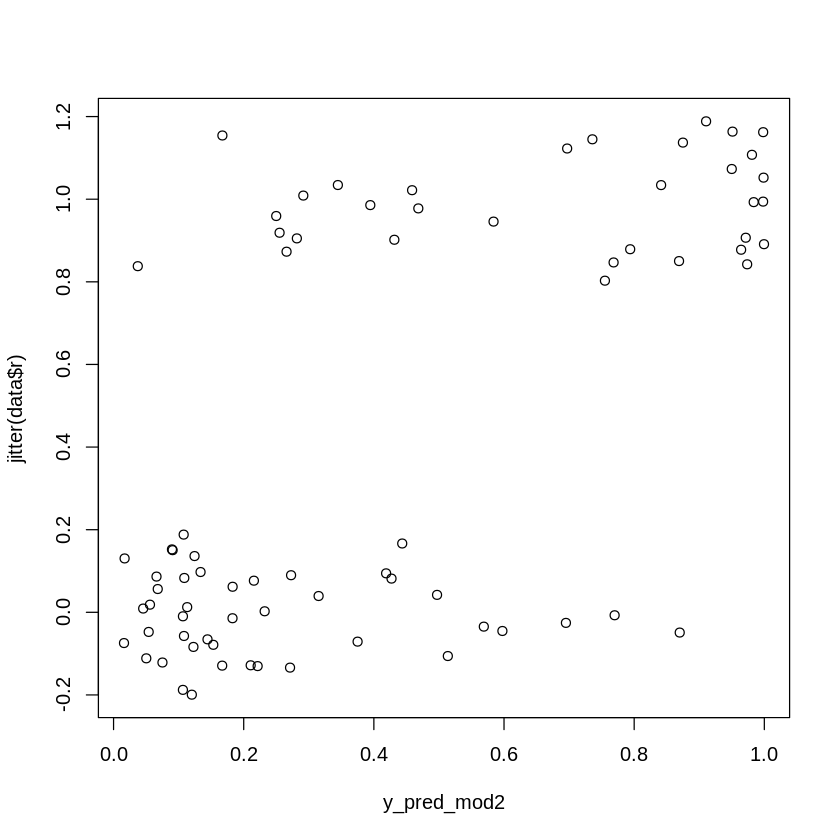

In [58]:
plot(y_pred_mod2, jitter(data$r))

The model seems to predict well, for those points where probability of crystals were high, they indeed were right and also vice-versa

In [97]:
data$r_pred = y_pred_mod2

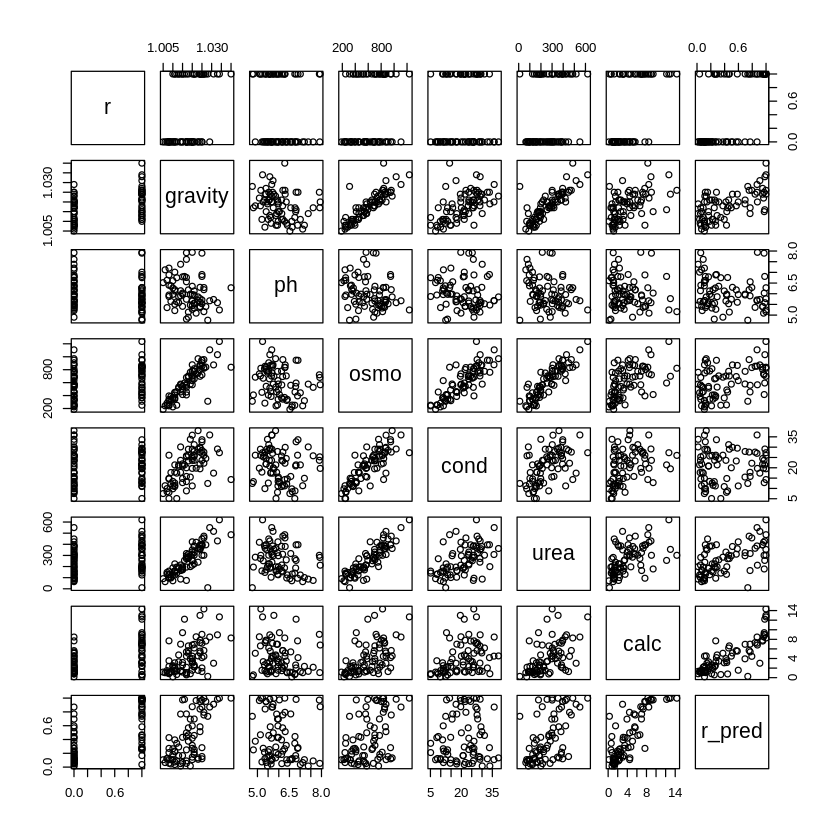

In [98]:
pairs(data)

### Creating a cutoff at 0.5

In [62]:
table0.5 = table(y_pred_mod2 > 0.5, data$r)

In [63]:
table0.5

       
         0  1
  FALSE 38 12
  TRUE   6 21

Therefore, 38 observations were correctly classified as belonging to 0 class and 21 observations were correctly classifed as belonging to the 1 class.

#### Finding Correct Classification Rate

In [64]:
sum(diag(table0.5)) / sum(table0.5)

[1] 0.7662338

**Suppose it's really bad to predict that there will be no Calcium Oxalate crystals when in reality there is one. (False Negatives)**

Currently there 12 False Negatives

We might decrease our threshold to lower values to accomodate them too.

In [65]:
table0.3 = table(y_pred_mod2 > 0.3, data$r)

In [66]:
table0.3

       
         0  1
  FALSE 32  7
  TRUE  12 26

Thus, the amount of False Negatives have decreased.

In [68]:
sum(diag(table0.3)) / sum(table0.3)

[1] 0.7532468

## True Classification Rate vs Threshold

In [72]:
install.packages("pracma")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [73]:
library(pracma)


Attaching package: ‘pracma’


The following object is masked from ‘package:boot’:

    logit




In [85]:
TCR = function(y_pred, y_true, n = 1000){
    
    threshold = numeric(n)
    classification_rate = numeric(n)
    threshold = linspace(0,1,n)
    
    for (i in 1:n){
        
        table_i = table(y_pred > threshold[i], y_true)
        classification_rate[i] = sum(diag(table_i)) / sum(table_i)
        
        
    }
    
    list("class_rate" = classification_rate, "thresh" = threshold )
    
}

In [88]:
tcr = TCR(y_pred = y_pred_mod2, y_true = data$r )

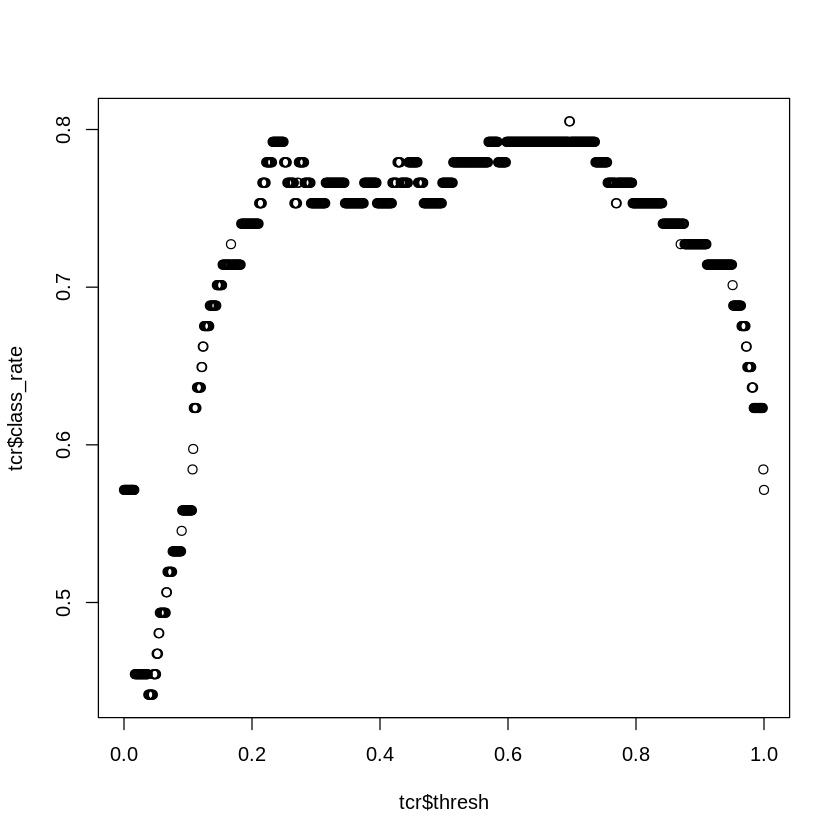

In [89]:
plot(tcr$class_rate ~ tcr$thresh)